<a href="https://colab.research.google.com/github/rodrigoGA/traffic-analysis/blob/main/2-%20Anomal%C3%ADas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anomalías

Continuando con el trabajo anterior se procederá a la detección de anomalías que puedan interferir en el análisis

Los valores atípicos en los datos pueden sesgar y engañar el proceso de entrenamiento de los algoritmos de aprendizaje automático, lo que resulta en tiempos de entrenamiento más largos, modelos menos precisos y, en última instancia, resultados más pobres.

## Importaciones y utilidades

In [ ]:
# importaciones
import pandas as pd
import numpy as np
from dateutil import rrule
from datetime import datetime, timedelta
import datetime as dt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point, Polygon
import pylab as pl
import matplotlib.pyplot as plt
import calmap
import seaborn as sns
from bokeh.plotting import figure, save
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
from numpy.random import seed
from numpy.random import randn
from numpy import percentile
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from statsmodels.graphics.tsaplots import plot_acf
from fiona.crs import from_epsg


output_notebook()

Loading BokehJS ...

In [ ]:
#utilidades
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)
    
def getPointCoords(row, geom, coord_type):
    """Calculates coordinates ('x' or 'y') of a Point geometry"""
    if coord_type == 'x':
        return row[geom].x
    elif coord_type == 'y':
        return row[geom].y

    
def getLineCoords(row, geom, coord_type):
    """Returns a list of coordinates ('x' or 'y') of a LineString geometry"""
    if coord_type == 'x':
        return list( row[geom].coords.xy[0] )
    elif coord_type == 'y':
        return list( row[geom].coords.xy[1] )



## Datasets

Se continua con el análisis tomando el resultado del dataset del paso anterior

In [ ]:
base_path_dataset='datasets'

conteo =pd.read_pickle(f'{base_path_dataset}/status/iu-montevideo-conteo-base.pkl')
sensores =pd.read_pickle(f'{base_path_dataset}/status/iu-montevideo-sensores-base.pkl')

## Anomalías

Primero, definamos anomalías. En el contexto de este análisis puede ser cualquier cosa que sea diferente o anormal y se desvíe sustancialmente de otros datos en la muestra o datos históricos.

En este caso es lo primero a buscar es valores menores a 0 

In [ ]:
print( 'cantidad de valores < 0 = ', conteo[conteo < 0].sum().sum())
conteo = conteo.mask(conteo < 0)

cantidad de valores < 0 =  0.0


### Desviación estándar

Siguiendo con lo dictado en el curso se evaluará la aplicación del método de la desviación estándar para eliminación de outliers

Si la distribución de datos es aproximadamente normal, aproximadamente el 68% de los valores de los datos se encuentran dentro de una desviación estándar de la media y aproximadamente el 95% están dentro de dos desviaciones estándar, y aproximadamente el 99,7% se encuentran dentro de tres desviaciones estándar

Por lo tanto, si se tiene algún punto de datos que sea más de 3 veces la desviación estándar, es muy probable que esos puntos sean anómalos o atípicos.

Sensor 24 - Percentiles: 25th=5.000, 75th=29.000, IQR=24.000
Sensor 24 - outliers: 0.0018550228310502282
Sensor 140 - Percentiles: 25th=0.000, 75th=0.000, IQR=0.000
Sensor 140 - outliers: 0.18969748858447488
Sensor 226 - Percentiles: 25th=0.000, 75th=1.000, IQR=1.000
Sensor 226 - outliers: 0.11078767123287671


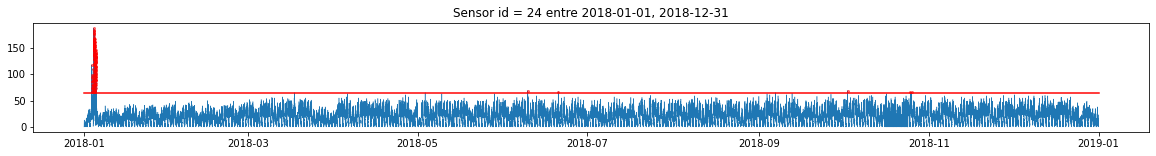

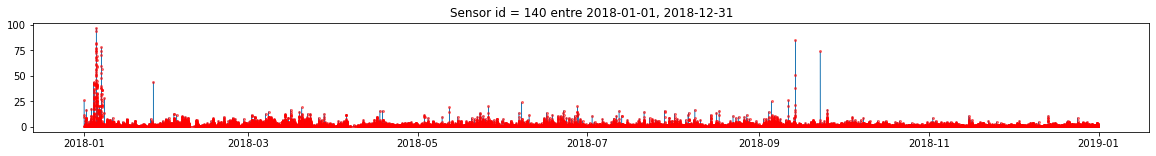

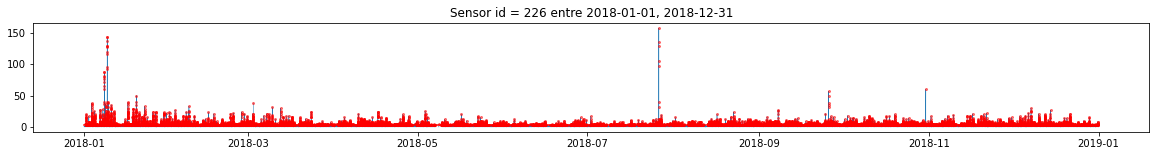

In [ ]:
def calculate_std(idSensor):
    #se completan los valores faltantes
    imputer = SimpleImputer(strategy='mean')
    data = imputer.fit_transform(conteo[[idSensor]])
    # calculate interquartile range
    q25, q75 = percentile(data, 25), percentile(data, 75)
    iqr = q75 - q25
    print(f'Sensor {idSensor} - Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    print(f'Sensor {idSensor} - outliers: { len(outliers) /len(data)}')
    # remove outliers
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return outliers, lower, upper

def pintar_limite(dateStart, dateEnd, idSensor):
    outliers, lower, upper =  calculate_std(idSensor)
    mask =pd.DataFrame(conteo[dateStart:dateEnd][idSensor])
    all_data=conteo[:][idSensor]
    pl.figure(figsize=(20, 2))
    plt.title(f"Sensor id = {idSensor} entre {dateStart}, {dateEnd}");
    pl.plot(mask.index,mask.values, linewidth=0.5)
    pl.plot((min(mask.index), max(mask.index)), (upper,upper), color='r')
    pl.plot (mask[mask[idSensor]>upper],marker='o', linestyle='none', color='r',alpha=0.5, markersize=2)

    
pintar_limite('2018-01-01', '2018-12-31', 24)
pintar_limite('2018-01-01', '2018-12-31', 140)
pintar_limite('2018-01-01', '2018-12-31', 226)
# pintar_limite('2018-10-01', '2018-12-31', 180)

Para el caso del sensor 24, e comportamiento es el esperado, en los casos de los sensores 140, 226, está marcando más puntos anormales de los deseados (18% de outliers). 
Esto es debido a que nuestros datos no siguen una desviación estandar



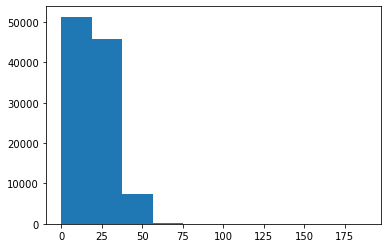

Sensor=24 mean=18.696 stdv=13.906
Sensor=24 Statistics=0.910, p=0.000
Sensor=24 does not look Gaussian (reject H0)


/media/rodrigo/Data/Linux/Programas/anaconda3/envs/tf/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


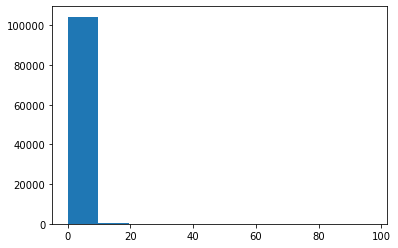

Sensor=140 mean=0.394 stdv=1.839
Sensor=140 Statistics=0.180, p=0.000
Sensor=140 does not look Gaussian (reject H0)


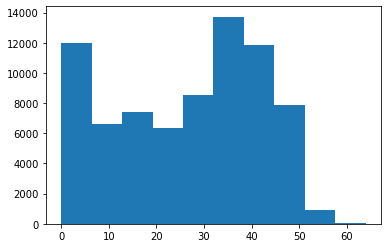

Sensor=266 mean=26.596 stdv=15.206
Sensor=266 Statistics=0.941, p=0.000
Sensor=266 does not look Gaussian (reject H0)


In [ ]:
def calulate_gauss(sensor_id):
    # seed the random number generator
    seed(1)
    # generate univariate observations
    data = conteo[:][sensor_id].dropna()
    # summarize
    pyplot.hist(data)
    pyplot.show()
    print(f'Sensor={sensor_id} mean=%.3f stdv=%.3f' % (mean(data), std(data)))
    
    stat, p = shapiro(data)
    print(f'Sensor={sensor_id} Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print(f' Sensor={sensor_id} looks Gaussian (fail to reject H0)')
    else:
        print(f'Sensor={sensor_id} does not look Gaussian (reject H0)')
        
calulate_gauss(24)
calulate_gauss(140)
calulate_gauss(266)

Debido a ello este metodo no es el indicado para este conjunto de datos

Una alternativa a al desviación estandar podría ser utilizar el método IQR (método de rango intercuartílico) que se calculan los percentiles ordenando las observaciones y no asumiendo una distribución gausseana

### Isolation Forest

La biblioteca scikit-learn proporciona una serie de métodos integrados para identificar valores atípicos en los datos.

iForest para abreviar, es un algoritmo de detección de anomalías basado en árboles. Se basa en modelar los datos normales de tal manera que se aíslen las anomalías que son pocas en número y diferentes en el espacio de características. A diferencia de la mayoría de los otros algoritmos de detección de valores atípicos buscan construir un perfil de instancias "normales" y luego marcar las instancias que no se ajustan a ese perfil de normalidad. 

A priori si trabajamos con una sola variable, por lo que es de eesperar obtener resultados muy similares que se utilizaramos IQR.
Añadimos el día de la semana cómo una propiedad a nuestro juego de datos

In [ ]:

ifConteo = conteo.copy()
ifConteo['l'] = (ifConteo.index.dayofweek  == 0).astype(float)
ifConteo['m'] = (ifConteo.index.dayofweek  == 1).astype(float)
ifConteo['x'] = (ifConteo.index.dayofweek  == 2).astype(float)
ifConteo['j'] = (ifConteo.index.dayofweek  == 3).astype(float)
ifConteo['v'] = (ifConteo.index.dayofweek  == 4).astype(float)
ifConteo['s'] = (ifConteo.index.dayofweek  == 5).astype(float)
ifConteo['d'] = (ifConteo.index.dayofweek  == 6).astype(float)
ifConteo.head()


,0,1,2,3,4,5,6,7,8,9,...,351,352,353,l,m,x,j,v,s,d
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,4.0,7.0,4.0,4.0,0.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:05:00,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,3.0,1.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:10:00,NaN,NaN,NaN,NaN,NaN,2.0,7.0,0.0,4.0,1.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,2.0,6.0,4.0,7.0,1.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 00:20:00,NaN,NaN,NaN,NaN,NaN,9.0,15.0,8.0,12.0,4.0,...,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0


En este caso trabajaremos con contamination=0.004

Sensor 24 - outliers: 0.00381468797564688%
Sensor 140 - outliers: 0.0038337138508371385%
Sensor 226 - outliers: 0.003928843226788432%
Sensor 180 - outliers: 0.003966894977168949%


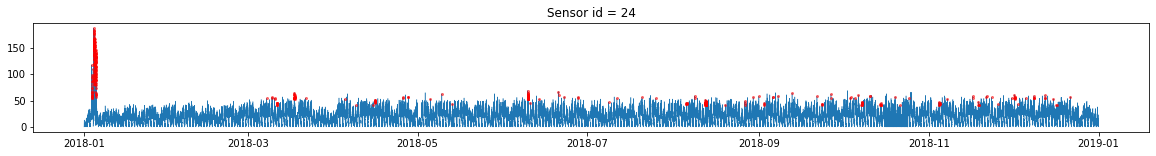

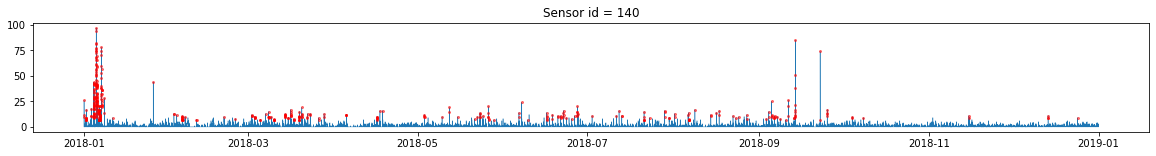

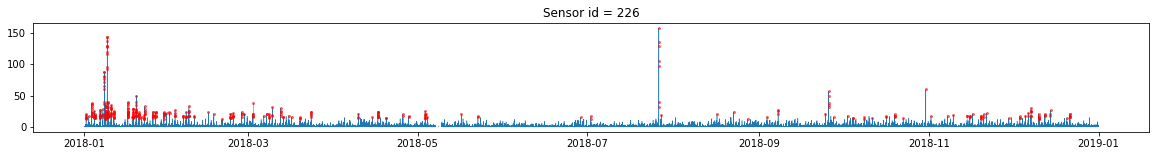

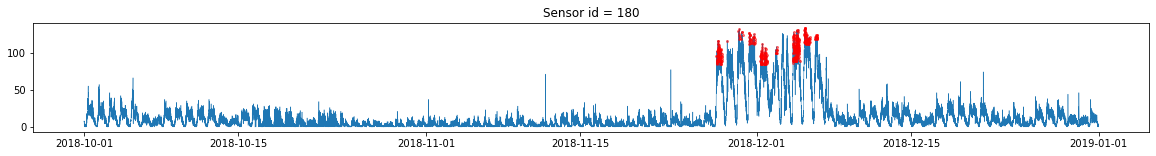

In [ ]:
iFcontamination=0.004


def calculte_iforest(idSensor):
    #se completan los valores faltantes
    imputer = SimpleImputer(strategy='mean')
    data = pd.DataFrame(imputer.fit_transform(ifConteo[[idSensor, 'l', 'm', 'x', 'j', 'v', 's', 'd']]))
    #se hace iForest
    model = IsolationForest(contamination=iFcontamination)
    return model.fit_predict(data)
    

def plot_iforest_sensor(start, end, idSensor):
    df = pd.DataFrame(conteo.copy()[:][idSensor])
    
    #calcula iForest
    values = pd.Series(calculte_iforest(idSensor)).apply(lambda x: 'yes' if (x== -1) else 'no')
    df['outliers'] = pd.Series(values.values , index=df.index)        
    #imprime porcentaje de outliers
    porcentajeOutliers =  df.query('outliers=="yes"')[idSensor].count() / len(df[:][idSensor])
    print(f'Sensor {idSensor} - outliers: {porcentajeOutliers}%')
    #grafica 
    mask=pd.DataFrame(df[start:end])
    pl.figure(figsize=(20, 2))
    plt.title(f"Sensor id = {idSensor}");
    pl.plot(mask.index,mask[idSensor].values, linewidth=0.5)
    pl.plot (mask.query('outliers=="yes"')[idSensor],marker='o', linestyle='none', color='r',alpha=0.5, markersize=2 )
    
    
plot_iforest_sensor('2018-01-01', '2018-12-31', 24)
plot_iforest_sensor('2018-01-01', '2018-12-31', 140) 
plot_iforest_sensor('2018-01-01', '2018-12-31', 226)
plot_iforest_sensor('2018-10-01', '2018-12-31', 180)  
    

Los resultados obtenidos son más parecidos a nuestro propósito.
Ahora procedemos a remover todos los puntos anómalos de todas las columnas

In [ ]:
print(f'Total de mediciones {conteo.count().sum()}')
print(f'NaN antes de iForest {conteo.isna().sum().sum()}')

for column in conteo.columns.tolist():
    values = pd.Series(calculte_iforest(column), index=conteo.index).apply(lambda x: True if (x== -1) else False)
    conteo.loc[values, column] = np.nan  

print(f'NaN despues de iForest {conteo.isna().sum().sum()}')   
    

Total de mediciones 25848368
NaN antes de iForest 11364112
NaN despues de iForest 11507199


In [ ]:
conteo.to_pickle(f'{base_path_dataset}/status/iu-montevideo-conteo-sinanomalias.pkl', protocol=4)
sensores.to_pickle(f'{base_path_dataset}/status/iu-montevideo-sensores-sinanomalias.pkl', protocol=4)